In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from library import *

## Problem 1

In [2]:
prob1 = pd.read_csv("problem1.csv")
prob1

,x
0,-0.002665
1,-0.045128
2,0.053635
3,0.010450
4,-0.016284
...,...
495,0.009279
496,-0.001121
497,0.075188
498,0.038520


In [3]:
prob1 = prob1['x']

In [4]:
np.random.seed(99)
returns_n, var_n = var_normal(prob1)
np.random.seed(99)
_, returns_t, var_t = var_t_MLE(prob1)
print("VaR of Normal distribution is ", var_n)
print("VaR of t distribution is ", var_t)
print("ES of Normal distribution is ", es(returns_n))
print("ES of t distribution is ", es(returns_t))

VaR of Normal distribution is  0.0816093938350451
VaR of t distribution is  0.07543967166231191
ES of Normal distribution is  0.10336079010489807
ES of t distribution is  0.11037516138718864


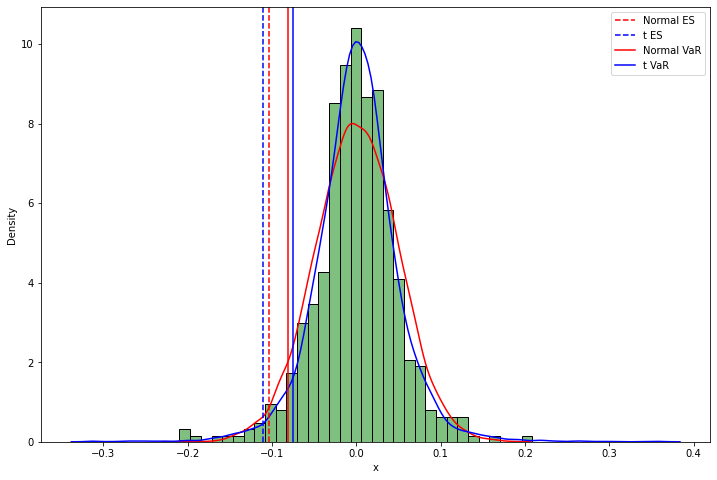

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(prob1, stat='density', alpha = 0.5, color = 'g')
sns.kdeplot(returns_n, color = 'r')
sns.kdeplot(returns_t, color = "b")
ax.axvline(-es(returns_n), color = "r", linestyle = "--", label='Normal ES')
ax.axvline(-es(returns_t), color = "b", linestyle = "--", label='t ES')
ax.axvline(-var_n, color = "r", label='Normal VaR')
ax.axvline(-var_t, color = "b", label='t VaR')
ax.legend()
plt.savefig('var_es.png', facecolor='white', dpi=250)

## Problem 2

In [6]:
prices = pd.read_csv("DailyPrices.csv")
prices.drop('Date', axis=1, inplace=True)
returns = return_calculate(prices).reset_index(drop=True)
returns.head()

,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
0,0.016127,0.023152,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
1,0.001121,-0.001389,-0.001167,0.010159,0.001041,0.008268,0.007784,-0.020181,0.000604,-0.001739,...,0.006757,-0.002429,0.005763,0.038879,0.009294,0.012244,0.003363,0.015301,-0.001389,-0.025984
2,-0.021361,-0.021269,-0.029282,-0.021809,-0.050943,-0.037746,-0.037669,-0.040778,-0.075591,-0.006653,...,-0.034949,0.005326,0.015017,-0.046988,-0.009855,0.004833,-0.030857,-0.031925,-0.033380,-0.028763
3,-0.006475,-0.009356,-0.009631,-0.013262,-0.022103,-0.016116,-0.013914,-0.007462,-0.035296,0.003987,...,-0.000646,-0.000908,0.007203,-0.000436,-0.003916,-0.005942,-0.013674,-0.004506,-0.003677,0.015038
4,-0.010732,-0.017812,-0.000729,-0.015753,-0.041366,-0.004521,-0.008163,-0.019790,-0.010659,-0.002033,...,0.009494,0.007121,-0.008891,0.003243,-0.001147,-0.000673,0.008342,-0.037654,-0.002246,-0.013605


In [7]:
def test_exp_weight_cov(returns):
    assert sum(exp_weighted_cov(returns,0.94)["SPY"])==0.012069269511443811

def test_fixes(n=500):
    sigma = non_psd(n)
    assert is_psd(near_psd(sigma)) == True
    assert is_psd(higham_psd(sigma, np.identity(len(sigma)))) == True
    root = chol_psd(near_psd(sigma))
    assert np.allclose(root@root.T, near_psd(sigma))

def test_sim(cov):
    nsim = 25000
    cov = np.cov(returns)
    sim_data = direct_sim(cov, nsim)
    assert frobenius(np.cov(sim_data),cov) < 5e-7
    sim_data = multivariate_normal_sim(cov, nsim)
    assert frobenius(np.cov(sim_data),cov) < 5e-7
    
    num, p0 = 10000, 100
    sigma, mu = 0.2, 0
    exp1, std1 = sim_CBM(num,p0, sigma)
    exp2, std2 = sim_ARS(num,p0, sigma)
    exp3, std3 = sim_GBM(num,p0, sigma)
    assert abs(exp1-p0)<0.15
    assert abs(std1-sigma)<0.15
    assert abs(exp2-p0)<0.15
    assert abs(std2-p0*sigma)<0.15
    assert abs(exp3-p0*np.exp(mu+sigma**2/2))<0.15
    assert abs(std3- p0*np.exp(sigma**2/2)*np.sqrt(np.exp(sigma**2)-1))<0.15

test_exp_weight_cov(returns)
test_fixes()
test_sim(cov)

In [8]:
returns = [0.01, -0.02, 0.03, 0.04, -0.05]
returns = pd.DataFrame(returns, columns = ['returns'])
portfolio = pd.DataFrame({'Stock': ['1', '2', '3'], 'Holding': [500, 1000, 750]})
prices = pd.DataFrame({
    '1': [120, 121, 122, 121, 120],
    '2': [1800, 1810, 1820, 1810, 1800],
    '3': [250, 245, 240, 245, 250]
})

def test_var():
    assert np.isclose(var(returns), 0.044)
    assert abs(var_normal(returns)[1] - 0.05) < 0.005
    assert abs(var_exp_weighted(returns['returns'])[1] - 0.05) < 0.007
    assert abs(var_t_MLE(returns)[2] - 0.05) < 0.005
    assert abs(var_ar1(returns)[1] - 0.05) < 0.1
    assert abs(var_hist(returns)[1] - 0.05) < 0.1

def test_var_portfolio():
    VaR = parametric_VAR(portfolio, prices)
    assert abs(VaR - 11000) < 1000
    VaR = monte_carlo_VAR(portfolio, prices)[1]
    assert abs(VaR - 11000) < 1000
    VaR = historical_VAR(portfolio, prices)[1]
    assert abs(VaR - 6000) < 1000

def test_calc_portfolio_value(portfolio, prices):
    assert calc_portfolio_value(portfolio, prices)[2] == 2047500

def test_es():
    assert es(returns['returns'].tolist()) == 0.05

test_var()
test_var_portfolio()
test_calc_portfolio_value(portfolio, prices)
test_es()

## Problem 3

In [9]:
portfolio = pd.read_csv("portfolio.csv")
prices = pd.read_csv("DailyPrices.csv")

In [10]:
port_a = list(portfolio.groupby('Portfolio'))[0][1]
port_b = list(portfolio.groupby('Portfolio'))[1][1]
port_c = list(portfolio.groupby('Portfolio'))[2][1]
prices.drop('Date', axis=1, inplace=True)

In [11]:
def model_VAR(portfolio, prices, lambd=0.94, alpha=0.05):
    current_prices, holdings, portfolio_value = calc_portfolio_value(portfolio, prices)
    prices = prices.loc[:,portfolio['Stock']]
    returns = return_calculate(prices).reset_index()
    returns = returns.drop(returns.columns[0],axis=1)
    returns = returns - returns.mean()
    
    U, t_dist_list = [], []
    for i in range(len(returns.columns)):
        x = returns.iloc[:,i]
        t_dist = var_t_MLE(x)[0]
        t_dist_list.append(t_dist)
        col = t_dist.cdf(x)
        U.append(col)
    U = [list(row) for row in zip(*U)]
    Z = stats.norm.ppf(U)
    r_spearman = stats.spearmanr(Z)[0]
    
    np.random.seed(9)
    # copula = stats.multivariate_normal(mean=np.zeros(len(prices.columns)), cov=r_spearman)
    # spearman = copula.rvs(size=1000)
    spearman = multivariate_normal_sim(r_spearman, 10000, var_explained=1-1e-9).T
    for i in range(len(returns.columns)):
            spearman[:,i] = t_dist_list[i].ppf(stats.norm.cdf(spearman[:,i]))
    
    sim_pv = (current_prices*holdings).T@spearman.T
    VaR = -np.percentile(sim_pv, alpha*100)
    return [sim_pv, VaR]

In [12]:
print('Portfolio A')
sim_pv, VaR = model_VAR(port_a, prices)
print('VaR: ', VaR)
print('ES: ', es(sim_pv))
print('')
print('Portfolio B')
sim_pv, VaR = model_VAR(port_b, prices)
print('VaR: ', VaR)
print('ES: ', es(sim_pv))
print('')
print('Portfolio C')
sim_pv, VaR = model_VAR(port_c, prices)
print('VaR: ', VaR)
print('ES: ', es(sim_pv))
print('')
print('Total')
sim_pv, VaR = model_VAR(portfolio, prices)
print('VaR: ', VaR)
print('ES: ', es(sim_pv))

Portfolio A
VaR:  7949.041686344149
ES:  10486.343674197444

Portfolio B
VaR:  6671.064314389528
ES:  8647.322575881006

Portfolio C
VaR:  5560.313478342462
ES:  7281.30679827259

Total
VaR:  19865.298398079103
ES:  26356.298234293536
